# Running Semigrand Canonical Monte Carlo Sampling

In [2]:
import numpy as np
import json
from pymatgen.core.structure import Structure
from smol.io import load_work

### 0) Load the previous LNO CE with electrostatics

In [3]:
work = load_work('basic_ce_ewald.mson')
expansion = work['ClusterExpansion']

### 1) Create a cluster expansion processor

The `CEProcessor` and `EwaldCEProcessor` classes represent the Monte Carlo simulation domain.

In [6]:
from smol.moca import EwaldCEProcessor

# Create a supercell matrix
# This specifies the size of the MC simulation domain.
sc_matrix = np.array([[6, 1, 1],
                      [1, 2, 1],
                      [1, 1, 2]])

# Create the processor
# In this case we will use the EwaldCEProcessor
# to handle the changes in the electrostatic interaction
processor = EwaldCEProcessor(expansion, sc_matrix)

# In a real scenario you may want a much larger processor.size
# An MC step is O(1) with the processor.size, meaning it runs at
# the same speed regardless of the size. However, larger sizes
# will need many more steps to reach equilibrium in an MC simulation.
print(f'The supercell size for the processor is {processor.size} prims.')

The supercell size for the processor is 16 prims.


### 2) Create an initial structure

In [8]:
from pymatgen.transformations.standard_transformations import OrderDisorderedStructureTransformation

# Here we will just use the order disordered transformation from
# pymatgen to get an ordered version of a prim supercell.
# The structure will have the same composition set in the prim.
transformation = OrderDisorderedStructureTransformation()

supercell = expansion.cluster_subspace.structure.copy()
supercell.make_supercell(sc_matrix)

# this can take a bit of time....
test_struct = transformation.apply_transformation(supercell)
print(test_struct.composition)

Li+8 Ni3+8 Ni4+8 O2-32


### 3) Create a semigrand ensemble
The `MuSemigrandEnsemble` class is used to run semigrand canonical MC by fixing relative chemical potentials.

In SGC chemical potential differences are set as boundary conditions. Any one of the active species can be used as reference.

In [15]:
from smol.moca import MuSemiGrandEnsemble

init_occu = processor.occupancy_from_structure(test_struct)

# relative chemical potentials are provided as a dict
chemical_potentials = {'Li+': 0, 'Vacancy': 0,
                       'Ni3+': 0, 'Ni4+': 0}

# Creating an SGC ensemble
ensemble = MuSemiGrandEnsemble(processor,
                               temperature=800,
                               chemical_potentials=chemical_potentials,
                               sample_interval=200,
                               initial_occupancy=init_occu)

### 3.1) Sweeping chemical potentials

Using a semigrand ensemble, we can sweep through relative chemical potentials and get average energies at various compositions.

Here we will sweep only through the relative chemical potential of vacancies.

In [70]:
dmus = np.arange(4, 7, .25)
concentration_avgs = []
energy_avg = []
sample_data = {}

for dmu in dmus:
    chemical_potentials['Vacancy'] = dmu
    ensemble = MuSemiGrandEnsemble(processor,
                               temperature=2000,
                               chemical_potentials=chemical_potentials,
                               sample_interval=100,
                               initial_occupancy=init_occu)
    ensemble.run(10000)
    ensemble.production_start = 100
    energy_avg.append(ensemble.average_energy)
    
    # this gets the composition in all active sites
    # excludes inactive sites (i.e. O2- in this case)
    # to get the composition per sublattice only
    # ensemble.average_sublattice_composition
    concentration_avgs.append(ensemble.average_composition)

    # it is also useful to save all the sample data
    # for more detailed analysis
    sample_data[dmu] = ensemble.data

Text(0, 0.5, 'Average total energy (eV)')

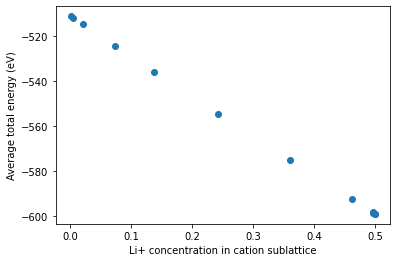

In [77]:
# Plot some results
import matplotlib.pyplot as plt
plt.plot([c['Li+'] for c in concentration_avgs],
          energy_avg, 'o')
plt.xlabel('Li+ concentration in cation sublattice')
plt.ylabel('Average total energy (eV)')